In [1]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
np.random.seed(100)

In [2]:
class neurona:
    # Lista con los pesos para las entradas del perceptron
    w=[]
    # Salida del perceptron
    y=0
    delta=0
    # Funcion de activacion: 1 = funcion sigmoide; 2 = funcion tangente hiperbolica
    f_activ=1
    # Tasa de aprendizaje
    n = 0.8
    
    # Inicializa pesos aleatorios segun la cantidad de entradas que recibira el perceptron
    # por lo general, n_entradas = entradas + bias
    # size_hiddenlayers es la cantidad de capas ocultas de la red neuronal.
    def __init__(self, n_entradas, size_hiddenLayers=1):
        self.w=np.random.rand(n_entradas)*np.sqrt(2/size_hiddenLayers)

    # Funcion de activacion/transferencia
    def factivacion(self, x):
        if(self.f_activ==1):
            # funcion sigmoide
            return 1/(1+math.exp(-x))
        elif(self.f_activ==2):
            # funcion tangente hiperbolica
            return ( 2/(1+math.exp(-2*x)) ) -1
        
    def dfactivacion(self, x):
        if(self.f_activ==1):
            # funcion sigmoide
            return x*(1-x)
        elif(self.f_activ==2):
            # funcion tangente hiperbolica
            return 1-(x*x)

    def predict(self, x):
        suma=0
        for i in range(len(x)):
            suma += x[i]*self.w[i]
            
        self.y = self.factivacion(suma)
    
    def train(self, x):
        for i in range( len(self.w) ):
            self.w[i] += self.n*self.delta*self.dfactivacion(self.y)*x[i]
    


In [3]:
class rn_multicapa:
    # Lista que almacena las capas ocultas del perceptron
    hiddenLayers = []
    # Lista que almacena los perceptrones de la capa de salida
    # Las salidas de la RN se encuentran en outputLayer[n].y
    outputLayer = []
    # Valor del sesgo
    vSesgo=1
    
    # inicializa una red neuronal
    # Layers es una lista que especifica los tamaños de las capas que tendra la red neuronal
    # Debe tener al menos 3 elementos.
    # ejemplo: [3,3,1] [3 entradas, 3 capas ocultas, 1 capa de salida]
    def __init__(self,Layers):
        self.hiddenLayers.clear()
        self.outputLayer.clear()        
        if(len(Layers)<3):
            print("Error: Muy pocas dimensiones")
            return
        # Agregamos la entrada del bias1
        Layers[0]+=1  
        # cantidad de capas ocultas de la rn
        n_capasOcultas = len(Layers)-2
        print(n_capasOcultas)
        # Inicializar las capas ocultas, segun lo especificado en Layers
        for idx,layer in enumerate(Layers[1:-1]):
            # almacena una capa temporalmente antes de agregarla a hiddenLayers
            tmp = []
            # crea (layer) neuronas y las enlista
            for n in range(layer):
                tmp.append( neurona(Layers[idx],n_capasOcultas))
            self.hiddenLayers.append(tmp)
         # Inicializar la capa de salida, segun lo especificado en Layers
        for n in range(Layers[-1]):  
            self.outputLayer.append( neurona(Layers[-2]+1,n_capasOcultas)) # agregar 1 entrada para el bias2        
        
    def predict(self, x):
        # Agrega temporalmente la entrada bias al conjunto de entrada
        x.append(self.vSesgo) 
        # Almacena temporalmente las salidas de las neuronas de una capa para pasarlas a la siguiente
        data = []
        # data[0] = capa de entradas
        # data[1:] = salidas de cada capa oculta
        data.append(x.copy())
        # Recorre las capas ocultas para obtener sus salidas
        for inputSet,layer in zip( data, self.hiddenLayers ):
            # almacena temporalmente las salidas las neuronas en la capa
            tmp = []
            # Recorre las neuronas de la capa
            for p in layer:
                p.predict(inputSet)
                tmp.append(p.y)
            # agreda la lista con las salidas de esta capa oculta a la lista data
            data.append(tmp)
        # Con el ultimo elemento de la lista data como entrada
        # calcula el output de las neuronas en la capa de salida
        # Agrega una entrada bias a la ultima capa oculta
        data[-1].append(self.vSesgo)
        for p in self.outputLayer:
            p.predict(data[-1])
            
        x.pop() 
        
    # Recibe un conjunto de entradas x y su conjunto de salidas correctas z
    def train(self, x, z):
        self.predict(x)        
        ## Calculo de deltas
        # Definimos los deltas de las neuronas en la capa de salida
        for p in range( len(self.outputLayer) ):
            self.outputLayer[p].delta = z[p]-self.outputLayer[p].y

        # Definimos los deltas de las neuronas en las capas ocultas
        # Retropropagacion: Comenzamos a calcular los deltas de cada nodo comenzando desde la ultima capa oculta
        allLayers = []
        for l in self.hiddenLayers:
            allLayers.append(l)
        allLayers.append(self.outputLayer)
        
        # Recorre las capas ocultas
        for layer in reversed( range( len(allLayers)-1 ) ):
            # Recorre las neuronas de cada capa
            for p in range( len(allLayers[layer]) ):
                suma = 0
                for np in allLayers[layer+1]:
                    suma += np.delta*np.w[p]
                allLayers[layer][p].delta = suma
        
        ## Calculo de nuevos pesos
        x.append(self.vSesgo)
        temp=[[]]
        # entrenar primera capa
        for p in self.hiddenLayers[0]:
            p.train(x)
            temp[0].append(p.y)
        x.pop()
        # entrenar capas intermedias
        for idx,layer in enumerate(self.hiddenLayers[1:]):
            temp.append([])
            for p in layer:
                p.train(temp[idx])
                temp[idx+1].append(p.y)
        # entrenar capa de salida
        temp[-1].append(self.vSesgo)
        for p in self.outputLayer:
            p.train(temp[-1])
        
        temp.clear()
        allLayers.clear()
        self.predict(x)
        

    def printWeights(self):
        print("--- Neuronas de las capas ocultas ---")
        print(f"<< Capa oculta 1 >>")
        for idx,p in enumerate(self.hiddenLayers[0]):
            print(f"\tNeurona {idx+1}:")
            for i,w in enumerate(p.w[:-1]):
                print(f"\t\tw{i+1} = {w}")
            print(f"\t\tb1 = {p.w[-1]}")
        for idx,layer in enumerate(self.hiddenLayers[1:]):
            print(f"<< Capa oculta {idx+2} >>")
            for p in range( len(layer) ):
                print(f"\tNeurona {p+1}:")
                for w in range(len(layer[p].w)):
                    print(f"\t\tw{w+1} = {layer[p].w[w]}")
        
        print("--- Neuronas de la capa de salida ---")
        for p in range( len(self.outputLayer) ):
            print(f"\tNeurona {p+1}:")
            for w in range(len(self.outputLayer[p].w[:-1])):
                print(f"\t\tw{w+1} = {self.outputLayer[p].w[w]}")
            print(f"\t\tb2 = {self.outputLayer[p].w[-1]}")
            

In [4]:
# Inicializa una red neuronal que recibe 3 inputs,
# tiene 6 perceptrones de entrada y 1 de salida
rn=rn_multicapa([3,8,4,2])

print("Pesos iniciales")
#rn.printWeights()

2
Pesos iniciales


In [5]:
setX = [[1,1,1],
        [1,1,0],
        [1,0,1],
        [1,0,0],
        [0,1,1],
        [0,1,0],
        [0,0,1],
        [0,0,0]]

# Set para un perceptron de salida
setZ = [[1],[0],[0],[1],[0],[1],[1],[0]]
# Set para dos perceptrones de salida
setZ = [[1,0],[0,1],[0,1],[1,0],[0,1],[1,0],[1,0],[0,1]]

In [6]:
def toVF(x):
    if(x>0.5):
        return 1
    else:
        return 0

In [7]:
print("Valores deseados:")
for x, z in zip(setX,setZ):
    print(f"{x}|{z}")

print("Valores predichos:")
print("x1 x2 | x1 XOR x2")
for s in setX:
    rn.predict(s)
    y=[]
    yVF=[]
    for n in rn.outputLayer:
        y.append(n.y)
        yVF.append(toVF(n.y))
    #print(  toVF(rn.outputLayer[0].y), f" => Y = {rn.outputLayer[0].y}" )
    print(f"{s} | {yVF} => y = {y}")

Valores deseados:
[1, 1, 1]|[1, 0]
[1, 1, 0]|[0, 1]
[1, 0, 1]|[0, 1]
[1, 0, 0]|[1, 0]
[0, 1, 1]|[0, 1]
[0, 1, 0]|[1, 0]
[0, 0, 1]|[1, 0]
[0, 0, 0]|[0, 1]
Valores predichos:
x1 x2 | x1 XOR x2
[1, 1, 1] | [1, 1] => y = [0.9573196797686326, 0.8614571163957205]
[1, 1, 0] | [1, 1] => y = [0.9559767309675071, 0.8602236499156862]
[1, 0, 1] | [1, 1] => y = [0.9564672755016367, 0.8606464507412308]
[1, 0, 0] | [1, 1] => y = [0.9544214052807192, 0.8587713083367345]
[0, 1, 1] | [1, 1] => y = [0.9563957906222236, 0.8606414555665689]
[0, 1, 0] | [1, 1] => y = [0.9542421091532954, 0.8587393270270406]
[0, 0, 1] | [1, 1] => y = [0.9551608223772549, 0.8594941758262372]
[0, 0, 0] | [1, 1] => y = [0.9519404294923909, 0.8566762823722059]


In [8]:
outputs_1 = {"[1,1,1]": [],
          "[1,1,0]": [],
          "[1,0,1]": [],
          "[1,0,0]": [],
          "[0,1,1]": [],
          "[0,1,0]": [],
          "[0,0,1]": [],
          "[0,0,0]": []}
outputs_2 = {"[1,1,1]": [],
          "[1,1,0]": [],
          "[1,0,1]": [],
          "[1,0,0]": [],
          "[0,1,1]": [],
          "[0,1,0]": [],
          "[0,0,1]": [],
          "[0,0,0]": []}
out_df_1 = pd.DataFrame(outputs_1)
out_df_2 = pd.DataFrame(outputs_2)

In [9]:
# Bucle de épocas de entrenamiento.
for j in range(2000):
    yvalues1 = []
    #yvalues2 = []
    for i in range(len(setX)):
        rn.predict(setX[i])
        yvalues1.append(rn.outputLayer[0].y)
        #yvalues2.append(rn.outputLayer[1].y)
    out_df_1.loc[len(out_df_1.index)] = yvalues1
    #out_df_2.loc[len(out_df_2.index)] = yvalues2
    
    for i in range(len(setX)):
        rn.train(setX[i], setZ[i])
        rn.predict(setX[i])

In [10]:
print("Valores predichos:")
print("x1 x2 | x1 XOR x2")
for s in setX:
    rn.predict(s)
    y=[]
    yVF=[]
    for n in rn.outputLayer:
        y.append(n.y)
        yVF.append(toVF(n.y))
    print(f"{s} | {yVF} => y = {y}")

Valores predichos:
x1 x2 | x1 XOR x2
[1, 1, 1] | [1, 0] => y = [0.9904710163598824, 0.009682644876972298]
[1, 1, 0] | [0, 1] => y = [0.013602555336990074, 0.9861817060286859]
[1, 0, 1] | [0, 1] => y = [0.012495408395767148, 0.9872700275689591]
[1, 0, 0] | [1, 0] => y = [0.9950715663886726, 0.005092240019196769]
[0, 1, 1] | [0, 1] => y = [0.009122966526593612, 0.9906254191895203]
[0, 1, 0] | [1, 0] => y = [0.9940138069455682, 0.0061576627253482254]
[0, 0, 1] | [1, 0] => y = [0.995172455353064, 0.004997377023715198]
[0, 0, 0] | [0, 1] => y = [0.009123328481379325, 0.9906250700539935]


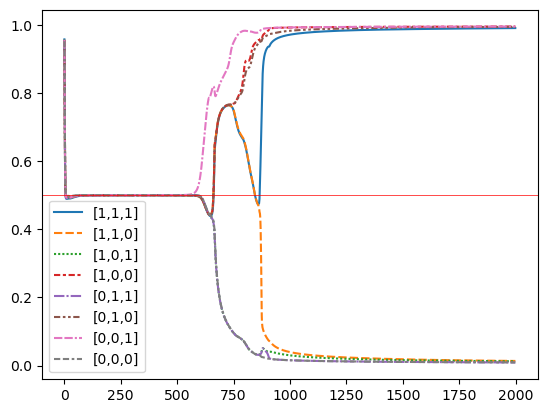

In [11]:
graph1 = sns.lineplot(out_df_1)
graph1.axhline(y=.5, linewidth=0.5, color='r') 

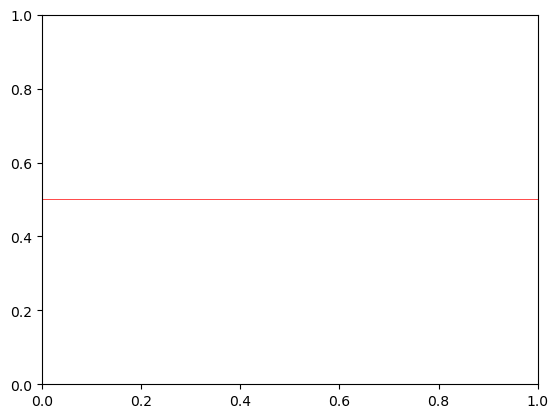

In [12]:
graph2 = sns.lineplot(out_df_2)
graph2.axhline(y=.5, linewidth=0.5, color='r') 